In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Set path for datasets.
trainPath = 'balanced_chest_xray/Train'
valPath = 'balanced_chest_xray/Val'
testPath = 'balanced_chest_xray/Test'
originaltestPath = 'chest_xray/test'

# Creating a generator for data augmentation for the training set.
print('Data in balanced data set')
trainGen = ImageDataGenerator(rotation_range=10 ,height_shift_range=0.2, width_shift_range=0.2, horizontal_flip=True)

# Preprosses the images in 128x128 grayscale in to batches.
trainBatch = trainGen.flow_from_directory(trainPath, target_size=(64,64), classes=['Pneumonia', 'Normal'], color_mode="grayscale", batch_size=16, shuffle=True)
vaildBatch = ImageDataGenerator().flow_from_directory(valPath, target_size=(64,64), classes=['Pneumonia', 'Normal'], color_mode="grayscale", batch_size=1, shuffle=False)
testBatch = ImageDataGenerator().flow_from_directory(testPath, target_size=(64,64), classes=['Pneumonia', 'Normal'], color_mode="grayscale", batch_size=1, shuffle=False)

# Preprosses the original test set in 128x128 grayscale in to batches.
print('\nOriginal test set')
testBatch_OG = ImageDataGenerator().flow_from_directory(originaltestPath, target_size=(64,64), classes=['Pneumonia', 'Normal'], color_mode="grayscale", batch_size=1, shuffle=False)


# Show the new labels incoding.
testBatch.class_indices

Using TensorFlow backend.


Data in balanced data set
Found 2232 images belonging to 2 classes.
Found 466 images belonging to 2 classes.
Found 468 images belonging to 2 classes.

Original test set
Found 624 images belonging to 2 classes.


{'Normal': 1, 'Pneumonia': 0}

In [2]:
from keras.preprocessing.image import load_img

# Function some creates 2 arrays for tensor and label form a given generator.
def Tensors_from_gen(generator, numOfTensors, label):
    tensors = []
    labels = []
    tensor_count = 0
    index_count = 0
    # While number of tensor is lower in given number ...
    while(tensor_count < numOfTensors):
        # if input class is equal to the class label ...
        if(generator[index_count][1][0][1] == label):
            # Append tensor and class to new array(tensors, labels) ...
            tensors.append(generator[index_count][0])
            labels.append(generator[index_count][1][0][0])
            # Count the number of tensors add to the new array ...
            tensor_count += 1
        # Count the number of iterations and used for indexing the tensors form the given generator.
        index_count += 1 
    return np.array(tensors), np.array(labels)

# Function some convert 4D tensors to 2D images.
def Tensor_to_image(tensors):
    images = []
    # for loop some loops over all tensors in a data set and remove batch and color dimensions.
    for tensor in tensors:
        tensor_3dim = np.squeeze(tensor, axis=0)
        images.append(np.squeeze(tensor_3dim, axis=2))  
    return np.array(images)

In [3]:
# Create arrays for tensor and classes for Normal and for Pneumonia with Tensors_from_gen fuction from test set.
tensorTestN, labelTestN = Tensors_from_gen(testBatch, numOfTensors=5, label=1)
tensorTestP, labelTestP = Tensors_from_gen(testBatch, numOfTensors=5, label=0)

# Convert the new arrays to images.
testImagesN = Tensor_to_image(tensorTestN)
testImagesP = Tensor_to_image(tensorTestP)

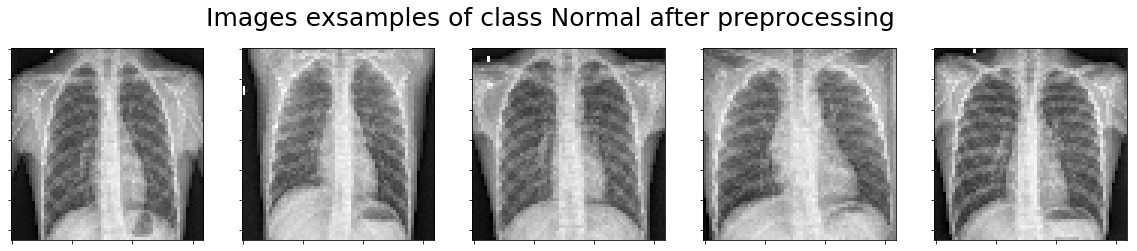

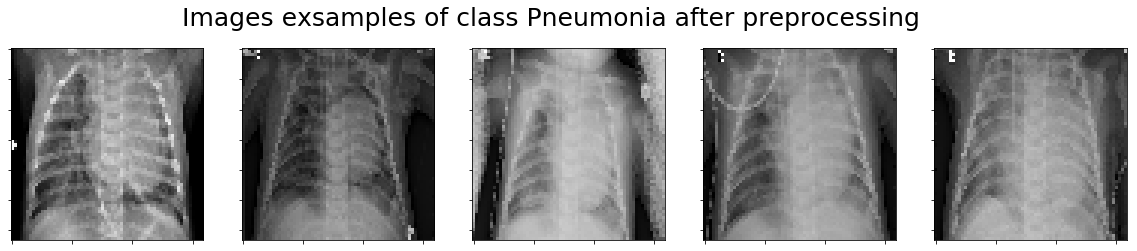

In [4]:
# Function some plots 5 images with title.
def Visalize_images(title, images):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    i = 0
    fig.suptitle(title, fontsize=25)
    # for loops some loops over every axes and shows a images
    for ax in axs.reshape(-1):
        ax.imshow(images[i], cmap='gray')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        i += 1
# Visalize images from the new images arrays with Visalize_images function   
Visalize_images('Images exsamples of class Normal after preprocessing', testImagesN)
Visalize_images('Images exsamples of class Pneumonia after preprocessing', testImagesP)

In [5]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential

# Defining the model structure.
model = Sequential()

model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', input_shape=(64,64,1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
__________

In [6]:
# Compiling the model with Adam optimizer and cross entropy for loss measurement.
model.compile('Adam',loss="binary_crossentropy", metrics=["accuracy"])

In [4]:
from keras.callbacks import ModelCheckpoint

# fitting the model to the training and validation set with modelcheckpoint function to save the best weights.
epoch=100
checkPoint = ModelCheckpoint(filepath='saved_model/weights.best.from_xray_cnn.hdf5', verbose=1, save_best_only=True, monitor='val_loss')


model.fit_generator(trainBatch, steps_per_epoch=155, validation_data=vaildBatch, validation_steps=len(vaildBatch), callbacks=[checkPoint], epochs=epoch)
    

Epoch 1/100
155/155 [==============================] - 33s 213ms/step - loss: 1.2494 - acc: 0.7536 - val_loss: 2.1486 - val_acc: 0.7403

Epoch 00001: val_loss improved from inf to 2.14856, saving model to saved_model/weights.best.from_scratch.hdf5
Epoch 2/100
155/155 [==============================] - 30s 195ms/step - loss: 0.9370 - acc: 0.8149 - val_loss: 0.9442 - val_acc: 0.6459

Epoch 00002: val_loss improved from 2.14856 to 0.94419, saving model to saved_model/weights.best.from_scratch.hdf5
Epoch 3/100
155/155 [==============================] - 30s 195ms/step - loss: 0.4738 - acc: 0.8633 - val_loss: 3.6791 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.94419
Epoch 4/100
155/155 [==============================] - 33s 214ms/step - loss: 0.3199 - acc: 0.8831 - val_loss: 0.2315 - val_acc: 0.8970

Epoch 00004: val_loss improved from 0.94419 to 0.23153, saving model to saved_model/weights.best.from_scratch.hdf5
Epoch 5/100
155/155 [==============================] - 34s 2

155/155 [==============================] - 33s 216ms/step - loss: 0.0834 - acc: 0.9694 - val_loss: 0.8772 - val_acc: 0.5258

Epoch 00041: val_loss did not improve from 0.07126
Epoch 42/100
155/155 [==============================] - 33s 214ms/step - loss: 0.0858 - acc: 0.9734 - val_loss: 0.2053 - val_acc: 0.9185

Epoch 00042: val_loss did not improve from 0.07126
Epoch 43/100
155/155 [==============================] - 34s 217ms/step - loss: 0.0806 - acc: 0.9677 - val_loss: 0.0850 - val_acc: 0.9657

Epoch 00043: val_loss did not improve from 0.07126
Epoch 44/100
155/155 [==============================] - 33s 215ms/step - loss: 0.0759 - acc: 0.9722 - val_loss: 0.1992 - val_acc: 0.9249

Epoch 00044: val_loss did not improve from 0.07126
Epoch 45/100
155/155 [==============================] - 34s 219ms/step - loss: 0.0775 - acc: 0.9702 - val_loss: 0.0817 - val_acc: 0.9764

Epoch 00045: val_loss did not improve from 0.07126
Epoch 46/100
155/155 [==============================] - 34s 217ms/st

In [10]:
# Evalutate the model and show loss and accuracy.
loss, acc = model.evaluate_generator(testBatch, steps=len(testBatch))

print('model performancens on balance data')
print('loss:{}'.format(loss) )
print('accuracy:{}'.format(acc))

model performancens on balance data
loss:1.5771916864218452
accuracy:0.6623931623931624


In [7]:
# loding the model from the checkpoint function to get the best weights based on validation set loss.
model.load_weights('saved_model/weights.best.from_xray_cnn.hdf5')
print('Best weights are loaded')

Best weights are loaded


In [10]:
# Evalutate the model and show loss and accuracy with best weights.
loss, acc = model.evaluate_generator(testBatch, steps=len(testBatch))

print('model performancens on balance data with best weights')
print('loss:{}'.format(loss) )
print('accuracy:{}'.format(acc))

model performancens on balance data with best weights
loss:0.4747115498066599
accuracy:0.8803418803418803


In [10]:
# Making prediction on balanced test set and the original.
pred = model.predict_generator(testBatch, steps=len(testBatch), verbose=True)
pred_OG = model.predict_generator(testBatch_OG, steps=len(testBatch_OG), verbose=True)

624/624 [==============================] - 4s 7ms/step


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
import numpy as np

# Preprocess the predicted test set and it predcitons for y true and y predict.
def Preprocess_yTrue_yPred(predict, testset):
    # Round the prediced data from test set to 1 and 0 for each class(True, False).
    pred = np.rint(predict)
    # Making y true variable with label(Normal: 0, Pneumonia: 1).
    y_true = testset.classes
    
    # Making y predict variable with appendig all Pneumonia predciton(Pneumonia True: 1, Pneumonia False: 0).
    y_pred = []
    for normal, Pneumonia in pred:
        y_pred.append(Pneumonia)
   
    # returning Y true and Y predict.
    return y_true, y_pred

# Show all the metrics(accuracy, precision, recall and fbeta score) for input y_True and y_predict.
def Metrics_results(y_true, y_pred):
    # Initializing all metricis for benchmarking
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, average='macro', beta=2)
    
    # Prnit benchmark resualts for test set.
    print('Accuracy:{}'.format(accuracy))
    print('Precision:{}'.format(precision))
    print('Recall:{}'.format(recall))
    print('Fbeta score:{}'.format(fbeta))

In [12]:
# Applaying Preprocess function to balance test set and predcit.
y_true, y_pred = Preprocess_yTrue_yPred(pred, testBatch)
# Applaying Preprocess function to original test set and predcit.
y_true_OG, y_pred_OG = Preprocess_yTrue_yPred(pred_OG, testBatch_OG)

# Print metrics results for balance test set.
print('Performs metrics for balance test set')
Metrics_results(y_true, y_pred)

# Print metrics results for original test set.
print('\nPerforms metrics for original test set')
Metrics_results(y_true_OG, y_pred_OG)

Performs metrics for balance test set
Accuracy:0.8803418803418803
Precision:0.8739495798319328
Recall:0.8888888888888888
Fbeta score:0.8803229492053382

Performs metrics for original test set
Accuracy:0.8717948717948718
Precision:0.7938931297709924
Recall:0.8888888888888888
Fbeta score:0.8711015063260132


In [13]:
# Function some apply augmentation on a given data set of tensors
def Tensor_AugTransformer(tensors, generator):
    tensors_transfomed = []
    # For loop some will loop over all tensors in data set ...
    for tensor in tensors:
        # Remove the first dimension for tensor ...
        tensor = np.squeeze(tensor, axis=0)
        # Apply augmentation on tensor ...
        tranform = generator.random_transform(tensor)
        # Add dimension back again.
        tensors_transfomed.append(np.expand_dims(tranform, axis=0))   
    return np.array(tensors_transfomed)

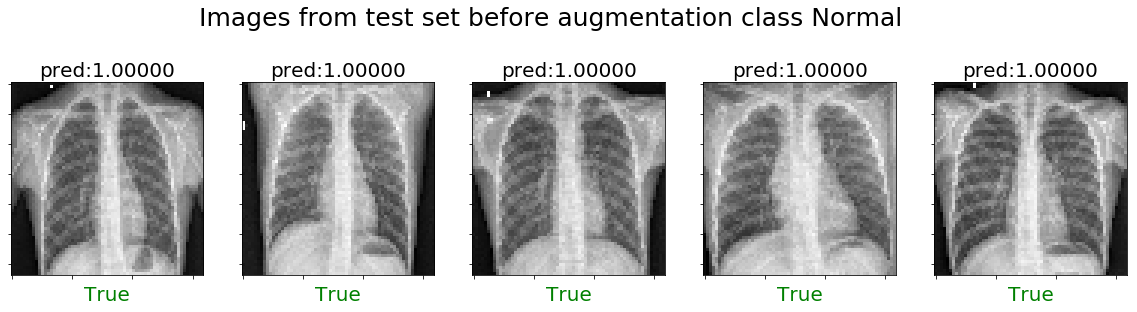

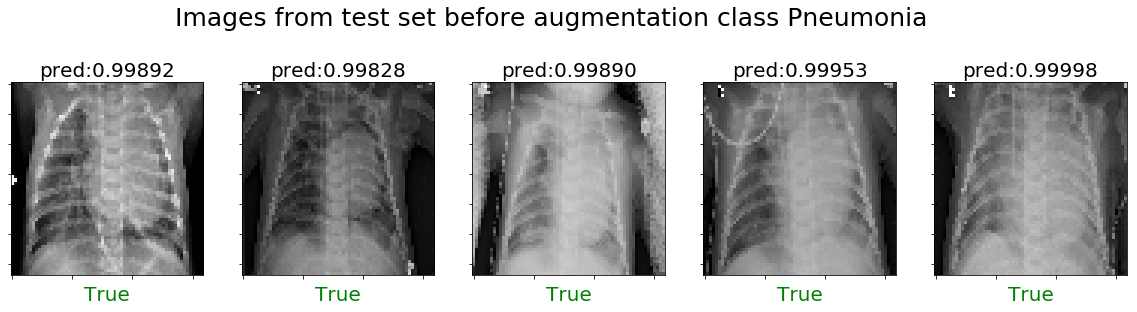

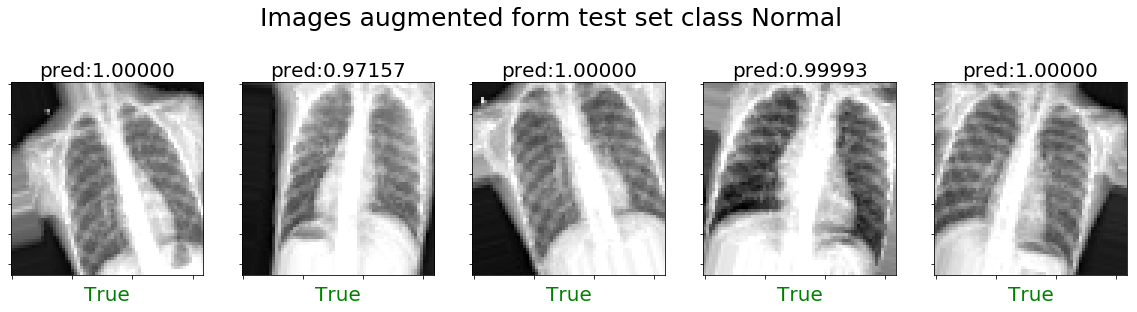

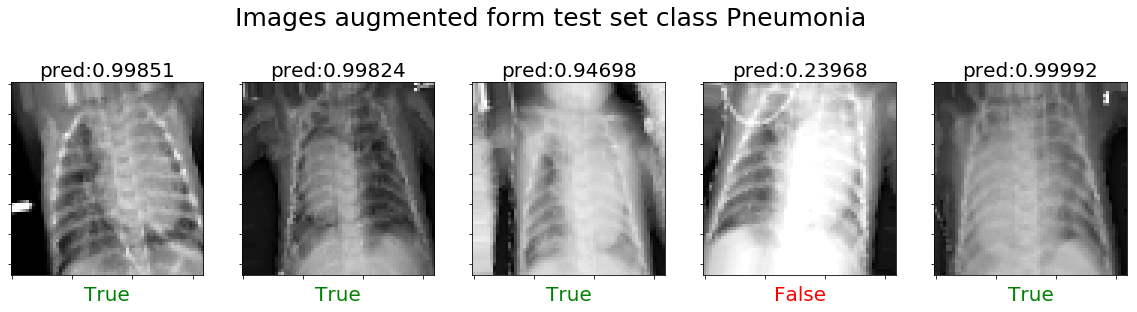

In [21]:
# Generator with augmentation some will apply rotation, shift left and right, horizontal flip and increased brightness
Robost_testGen = ImageDataGenerator(rotation_range=20 ,height_shift_range=0.1, width_shift_range=0.1, horizontal_flip=True,
                                    brightness_range=(1.0,1.2))

# Apply augmentation from Robost_testGen function on test set tensors
tensorTestN_Aug = Tensor_AugTransformer(tensorTestN, Robost_testGen)
tensorTestP_Aug = Tensor_AugTransformer(tensorTestP, Robost_testGen)
# Predict augmented test set tensors for each class.
testN_pred_Aug = [model.predict(i) for i in tensorTestN_Aug ]
testP_pred_Aug = [model.predict(i) for i in tensorTestP_Aug ]
# Convert augmented test set tensors to images.
imageTestN_Aug = Tensor_to_image(tensorTestN_Aug)
imageTestP_Aug = Tensor_to_image(tensorTestP_Aug)
# Predcit test set tensors for each class without augmentation.
testN_pred = [model.predict(i) for i in tensorTestN ]
testP_pred = [model.predict(i) for i in tensorTestP ]

# Create a function some will visualize images from input and predicions them.
def visualize_images_Predcions(images_tran, pred, Title, ImageClass):
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    
    i = 0
    fig.suptitle(Title, fontsize=25)
    # For loop some will loop over all axses ...
    for ax in axs.reshape(-1):
        # Show images from given input images set for all axes ...
        ax.imshow(images_tran[i], cmap='gray')
        # Set X and y ticklabels to empty..
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # Show predicions for all input images ...
        ax.set_title('pred:{:.5f}'.format(pred[i][0][ImageClass]), fontsize=20)
        # If prediction of the giving label are more in 50% ...
        if(np.rint(pred[i][0][ImageClass]) == 1):
            # Set Xlabel to True in green color for the given image ...
            ax.set_xlabel('True', fontsize=20)
            ax.xaxis.label.set_color('Green')
        # Else prediction are less in 50% ...
        else:
            # Set Xlabel to False in red color.
            ax.set_xlabel('False', fontsize=20)
            ax.xaxis.label.set_color('Red')
        i += 1

# Visualize 5 images from each class (normal and Pneumonia) and prediction for each image.
visualize_images_Predcions(testImagesN, testN_pred, 'Images from test set before augmentation class Normal', ImageClass= 1)
visualize_images_Predcions(testImagesP, testP_pred, 'Images from test set before augmentation class Pneumonia', ImageClass= 0)

# Visualize 5 images from each class (normal and Pneumonia) with augmentation and prediction for each image.
visualize_images_Predcions(imageTestN_Aug, testN_pred_Aug, 'Images augmented form test set class Normal', ImageClass= 1)
visualize_images_Predcions(imageTestP_Aug, testP_pred_Aug, 'Images augmented form test set class Pneumonia', ImageClass = 0)